In [2]:
# This notebook tries to find the relationship between certain wavelet subbands and the noise present in images.
# The understandings from this notebook will help in designing a network that uses wavelets to achieve better 
# denoised outputs by paying attention to high / low frequency components separately.

In [3]:
from tensorflow import keras
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT

# Custom Activation function Layer
import tensorflow_wavelets.Layers.Threshold as Threshold

In [4]:
import sys

from skimage.metrics import structural_similarity as ssim

from skimage.util import view_as_blocks

import numpy as np

from skimage.metrics import peak_signal_noise_ratio

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras import backend as K

from sklearn.model_selection import train_test_split

from data_importer import load_testing_images
from data_importer import load_training_images, denormalize, trunc

import matplotlib.pyplot as plt


# Common testing image pairs (used to evaluate all models)

noisy_images, ground_truth_images = load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', load_limited_images=True, num_images_to_load=200)

_n, _g = load_training_images('../../../../Dataset/LowDoseCTGrandChallenge/Selected_Image_Pairs/', load_limited_images=False)
noisy_images = np.concatenate((noisy_images, _n), axis=0)
ground_truth_images = np.concatenate((ground_truth_images, _g), axis=0)

noisy_images = np.squeeze(noisy_images, axis=-1)
ground_truth_images = np.squeeze(ground_truth_images, axis=-1)

loaded training images x and y of len :  200 200  respectively
type of train images x :  float64
range of values in train images :  0.0 0.576171875
type of train images y :  float64
loaded training images x and y of len :  5 5  respectively
type of train images x :  float64
range of values in train images :  0.0 0.915283203125
type of train images y :  float64


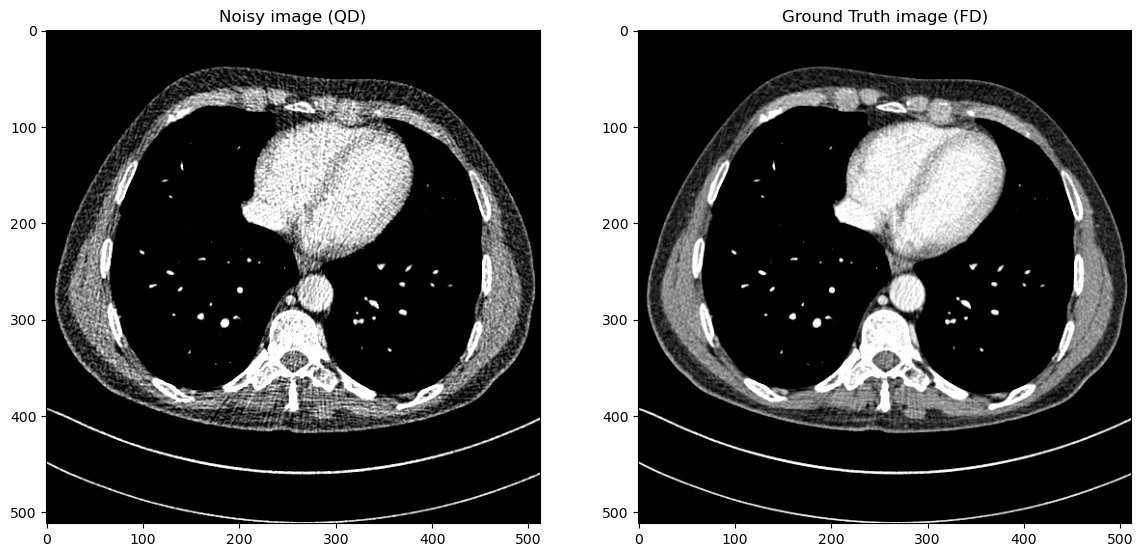

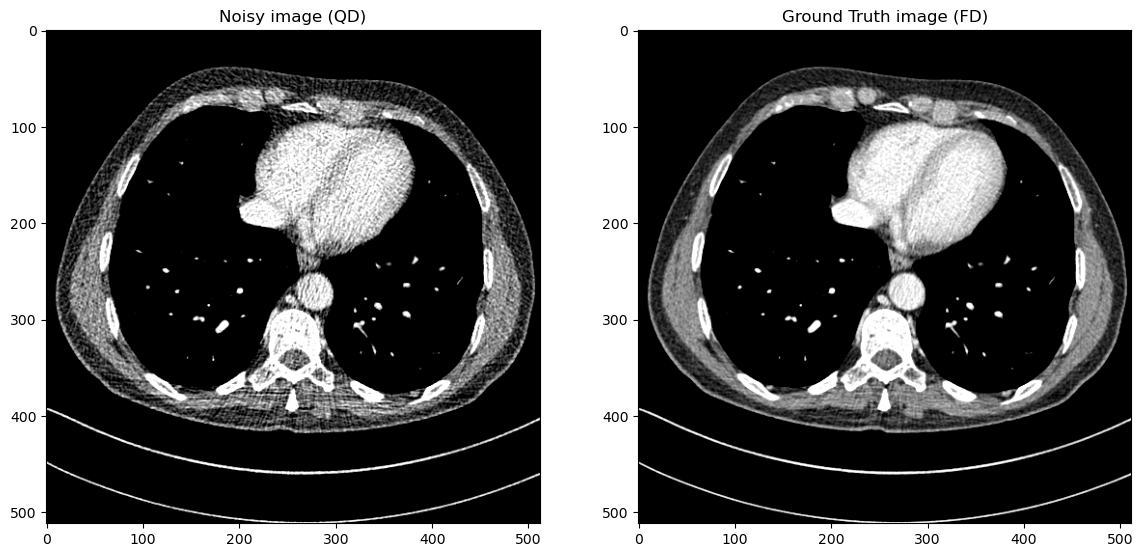

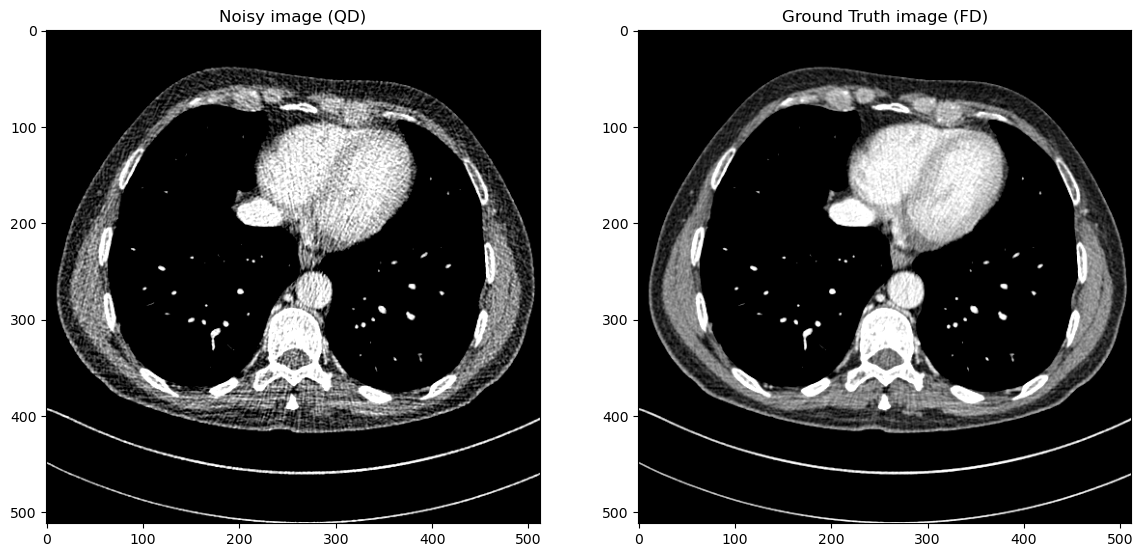

In [5]:
from data_importer import denormalize, trunc

for i in range(6, 15, 4):
    f, axarr = plt.subplots(1,2, figsize=(14,14))
    axarr[0].imshow(trunc(denormalize(noisy_images[i])), vmin=-160.0, vmax=240.0, cmap='gray')
    axarr[0].set_title("Noisy image (QD)")
    axarr[1].imshow(trunc(denormalize(ground_truth_images[i])), vmin=-160.0, vmax=240.0, cmap='gray')
    axarr[1].title.set_text("Ground Truth image (FD)")
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image

def display_and_get_all_wavelet_coeffs(image):

    coeffs2 = pywt.dwt2(image, 'haar')
    
    LL, (LH, HL, HH) = coeffs2
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Display the original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display the wavelet bands
    titles = ['Approximation', 'Horizontal detail', 'Vertical detail', 'Diagonal detail']
    for i, a in enumerate([LL, LH, HL, HH]):
        axes[i+1].imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        axes[i+1].set_title(titles[i])
        axes[i+1].axis('off')

    plt.show()
    
    return LL, (LH, HL, HH)
    
 

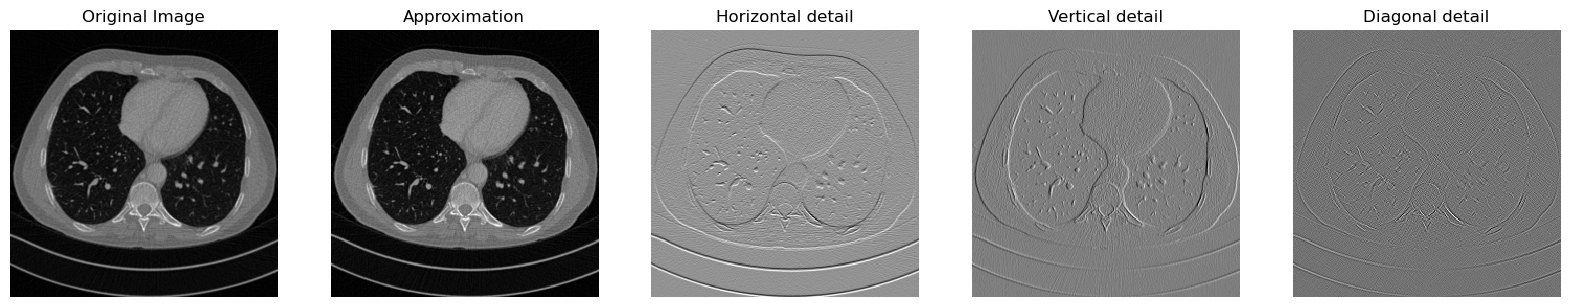

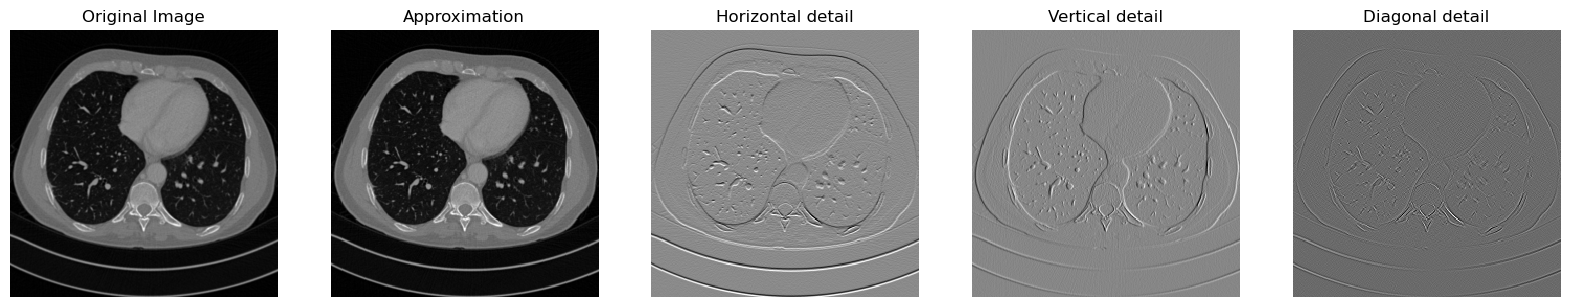

In [7]:
wavelet_bands_noisy = display_and_get_all_wavelet_coeffs(noisy_images[0])
wavelet_bands_clean = display_and_get_all_wavelet_coeffs(ground_truth_images[0])

horizontal detail


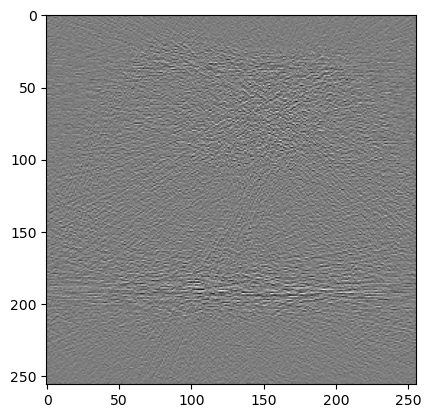

vertical detail


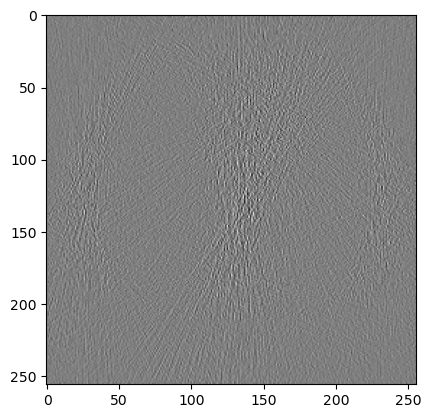

diagonal detail


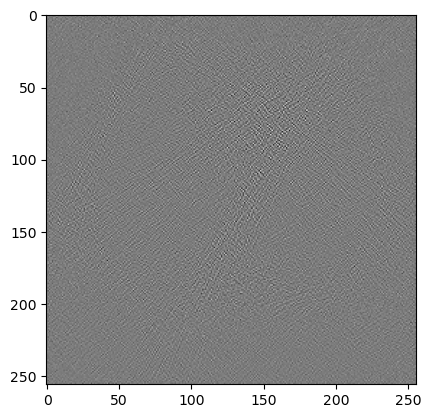

In [8]:
# For each subband, find the difference between clean and ground truth band.
print('horizontal detail')
plt.imshow(wavelet_bands_noisy[1][0] - wavelet_bands_clean[1][0], cmap='gray')
plt.show()

print('vertical detail')
plt.imshow(wavelet_bands_noisy[1][1] - wavelet_bands_clean[1][1], cmap='gray')
plt.show()

print('diagonal detail')
plt.imshow(wavelet_bands_noisy[1][2] - wavelet_bands_clean[1][2], cmap='gray')
plt.show()

### As we can see, nothing is visibally noticable. So, it might be better to use skip connections in the model that will use high frequency subbands (HL, LH, HH) and try to make the model increase the metrics by heavily denoising the low frequency components, but at the same time go light on the high frequency components